<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/DiffractGPT_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffractGPT: Atomic Structure Determination from X-ray Diffraction Patterns using Generative Pre-trained Transformer

https://doi.org/10.26434/chemrxiv-2024-ztp85


## Abstract:

Crystal structure determination from powder diffraction patterns is a complex challenge in materials science, often requiring extensive expertise and computational resources. This study introduces DiffractGPT, a generative pre-trained transformer model designed to predict atomic structures directly from X-ray diffraction (XRD) patterns. By capturing the intricate relationships between diffraction patterns and crystal structures, DiffractGPT enables fast and accurate inverse design. Trained on thousands of atomic structures and their simulated XRD patterns from the JARVIS-DFT dataset, we evaluate the model across three scenarios: (1) without chemical information, (2) with a list of elements, and (3) with an explicit chemical formula. The results demonstrate that incorporating chemical information significantly enhances prediction accuracy. Additionally, the training process is straightforward and fast, bridging gaps between computational, data science, and experimental communities. This work represents a significant advancement in automating crystal structure determination, offering a robust tool for data-driven materials discovery and design.

# Table of contents

1. Installation of [AtomGPT](https://github.com/usnistgov/atomgpt)
2. Loading the model
3. Helper functions
4. Inference on theoretical XRD pattern
5. Inference on experimental XRD pattern from RRUFF


Author: Kamal Choudhary (kamal.choudhary@nist.gov)

# Installation

In [1]:
!pip install -q git+https://github.com/usnistgov/jarvis.git@develop
!pip install -q git+https://github.com/usnistgov/atomgpt.git@develop
!pip install -q xformers==0.0.25.post1
!pip install -q bitsandbytes ase
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Loading the model

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_id = "knc6/diffractgpt_mistral_chemical_formula"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

# Helper functions

In [3]:
%%time
from jarvis.analysis.diffraction.xrd import XRD
from jarvis.core.atoms import Atoms
from jarvis.db.figshare import get_jid_data
import numpy as np
import torch
from jarvis.core.lattice import Lattice
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_error
from ase.visualize import view
import time
from scipy import stats
from jarvis.io.vasp.inputs import Poscar
from jarvis.core.atoms import ase_to_atoms
import numpy as np
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.ndimage import gaussian_filter1d
from atomgpt.inverse_models.utils import gen_atoms,text2atoms,main_spectra
from jarvis.analysis.diffraction.xrd import baseline_als, recast_array, sharpen_peaks, smooth_xrd, processed
import matplotlib.pyplot as plt

%matplotlib inline

# torch.cuda.is_available = lambda : False
device = "cuda" if torch.cuda.is_available() else "cpu"
alpaca_prompt = """Below is a description of a material..

### Instruction:
{}

### Input:
{}

### Output:
{}"""







/usr/local/lib/python3.11/dist-packages/atomgpt/inverse_models/kernels/fast_lora.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd
/usr/local/lib/python3.11/dist-packages/atomgpt/inverse_models/kernels/fast_lora.py:70: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_bwd
/usr/local/lib/python3.11/dist-packages/atomgpt/inverse_models/kernels/fast_lora.py:206: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd
/usr/local/lib/python3.11/dist-packages/atomgpt/inverse_models/kernels/fast_lora.py:227: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @

CPU times: user 5.04 s, sys: 594 ms, total: 5.64 s
Wall time: 10.2 s


# Inference on theoretical XRD pattern

System
1.0
4.73716 0.0 2.735
1.57905 4.46624 2.735
0.0 0.0 5.47
B La 
6 1 
direct
0.239 0.761 0.761 B
0.761 0.761 0.239 B
0.761 0.239 0.761 B
0.761 0.239 0.239 B
0.239 0.239 0.761 B
0.239 0.761 0.239 B
0.0 0.0 0.0 La

CPU times: user 24 s, sys: 2.33 s, total: 26.3 s
Wall time: 30.2 s


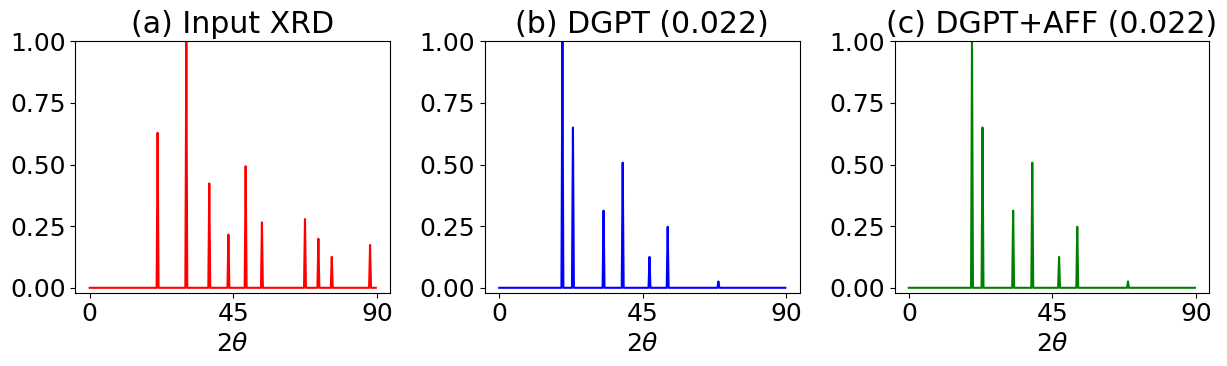

In [4]:
%%time
# https://www.ctcms.nist.gov/~knc6/static/JARVIS-DFT/JVASP-19821.xml
from jarvis.io.vasp.inputs import Poscar
pos="""LaB6
1.0
4.154998579020728 0.0 0.0
0.0 4.154998579020728 -0.0
0.0 0.0 4.154998579020728
La B
1 6
Cartesian
0.0 0.0 0.0
3.3248945674454897 2.0775 2.0775
0.8301054325545105 2.0775 2.0775
2.0775 2.0775 3.3248945674454897
2.0775 2.0775 0.8301054325545105
2.0775 0.8301054325545105 2.0775
2.0775 3.3248945674454897 2.0775
"""
atoms=Poscar.from_string(pos).atoms
y_new_str,cccc = smooth_xrd(atoms=atoms,intvl=0.3,thetas=[0,90])
main_spectra(model=model,spectra=[[y_new_str,cccc]],max_new_tokens=1624,formulas=["LaB6"],tokenizer=tokenizer,filename=None,calculator=None,alpaca_prompt=alpaca_prompt)

# Inference on experimental XRD pattern from RRUFF

In [5]:
!wget https://rruff.info/index.php/r=file_download/file_type=rruff/table=sample_child_record_powder/sample_id=575/file_id=4415 -O Si.xy

--2025-02-02 11:11:48--  https://rruff.info/index.php/r=file_download/file_type=rruff/table=sample_child_record_powder/sample_id=575/file_id=4415
Resolving rruff.info (rruff.info)... 128.196.236.195
Connecting to rruff.info (rruff.info)|128.196.236.195|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://rruff.info/tmp_rruff/Silicon__R050145-1__Powder__Xray_Data_XY_Processed__4415.rruff [following]
--2025-02-02 11:11:51--  https://rruff.info/tmp_rruff/Silicon__R050145-1__Powder__Xray_Data_XY_Processed__4415.rruff
Reusing existing connection to rruff.info:443.
HTTP request sent, awaiting response... 200 OK
Length: 171669 (168K)
Saving to: ‘Si.xy’

Si.xy               100%[===================>] 167.65K  --.-KB/s    in 0.05s   

2025-02-02 11:11:52 (3.10 MB/s) - ‘Si.xy’ saved [171669/171669]



In [ ]:
def load_exp_file(filename="", intvl=0.3,separator=","):
    # df = pd.read_csv(
    #     filename,
    #     skiprows=1,
    #     sep=" ",
    #     engine="python",
    # )
    #df=pd.read_csv(filename,skiprows=1,sep=separator,names=["X","Y"],comment="#",)
    df=pd.read_csv(filename,sep=separator,names=["X","Y"],comment="#",)
    if ".txt" in filename:

        with open(filename, "r") as f:
            lines = f.read().splitlines()
        for i in lines:
            if "##IDEAL CHEMISTRY=" in i:
                formula = Composition.from_string(
                    i.split("##IDEAL CHEMISTRY=")[1]
                    .replace("_", "")
                    .replace("^", "")
                    .replace("+", "")
                ).reduced_formula

                tmp = (
                    i.split("##IDEAL CHEMISTRY=")[1]
                    .replace("_", "")
                    .split("&#")[0]
                )
                formula = parse_formula(tmp)
                print("formula",formula, i)

    else:
        formula = filename.split("_")[0]
    # x = df["X"].values
    # y = df["Y"].values
    x=np.array(df.X.values,dtype='float')
    y=np.array(df.Y.values,dtype='float')
    y=y/np.max(y)
    # if df["Z"].isnull()[0]:
    #     y = df["Y"].values
    # else:
    #     y = df["Z"].values
    # y=np.array(y)
    # y=y/np.max(y)
    x, y_corrected = processed(x=x, y=y, intvl=intvl,background_subs=True)
    return formula, x, y_corrected



formulas=[]
spectra=[]
filename='Si.xy'
formula, x, y = load_exp_file(filename=filename, intvl=0.3)
y[y<0.05]=0
formulas.append("Si")
spectra.append(y)

main_spectra_exp(
    model=model,
    tokenizer=tokenizer,
    filename=None,
    # panels=[str(j) for j in np.arange(100)],
    calculator=None,
    device=device,
    spectra=spectra,
    formulas=formulas,
)